# Tree-Based Models for Mortality Prediction in FHS

## Setup

### Importing libraries

In [172]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Importing Data + Preprocessing

In [174]:
df = pd.read_csv(r'C:\Users\danie\Desktop\CICOM\FHS_medi\fhs_imp1_pyth.csv')
df.head()

,AGE,SEX,SYSBP,DIABP,CURSMOKE,CIGPDAY,HEARTRTE,educ,PREVCHD,PREVAP,...,HOSPMI,MI_FCHD,STROKE,CVD,ANYCHD,HYPERTEN,BMI,DIABETES,DEATH,label
0,52,1,121.0,66.0,0,0,69,4,0,0,...,1,1,0,1,1,0,24.85,0,0,test
1,58,2,108.0,66.0,0,0,80,2,0,0,...,0,0,0,0,0,0,28.50,0,0,test
2,54,1,141.0,89.0,1,30,75,1,0,0,...,0,0,0,0,0,0,25.34,0,0,train
3,67,2,183.0,109.0,1,20,60,3,0,0,...,0,0,1,1,0,1,30.18,0,1,test
4,58,2,155.0,90.0,1,30,74,3,0,0,...,0,0,0,0,0,1,24.61,0,0,train


In [176]:
df = pd.read_csv(r'C:\Users\danie\Desktop\CICOM\FHS_medi\fhs_imp1_pyth.csv')

# pre-processing: Converted certain variables to factors
categorical_vars = ['SEX', 'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'ANGINA',
       'HOSPMI', 'MI_FCHD', 'STROKE', 'CVD', 'ANYCHD', 'HYPERTEN',
       'DIABETES', 'DEATH']
for col in categorical_vars:
    df[col] = df[col].astype('category')

# pre-processing: Robust Scaler -  more robust to outliers
scaler = preprocessing.RobustScaler()
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Train-Test Split (80/20)
trains = df[df['label'] == 'train']
tests = df[df['label'] == 'test']

# splitting predictor and label
X_train = trains.drop(['DEATH', 'label'], axis=1)
y_train = trains['DEATH']
X_test = tests.drop(['DEATH', 'label'], axis=1)
y_test = tests['DEATH']

## Random Forest

#### Optimizing using Grid Search CV

Paper for setting the grid: https://ieeexplore.ieee.org/abstract/document/8947569?casa_token=mzR6aCijVwUAAAAA:HFgC7dvVYAOLHI4Rkx2-nxKIE0TaNZAakjeARGKuXVrGwELLyupr3ebdDxyUXjgRx-F0aXsnMxk

- recommends number of trees between 20 to 100, and increasing to 150 for datasets with more than 500k observations
- number of features should be between between 2 and 0.7*maxFeatures
- tree depth should be between 2 to 0.7*maxFeatures
- the minimum number of objects in each leaf should be from 1 to 50
- But these datsets were very large, though they had imbalanced case/outcome, like in our dataset

In [13]:
param_grid = {
    'n_estimators': [x for x in range(20,110,10)],
    'max_features' : [x for x in range(2,round(0.7*len(X_train.columns))+1)],
    'max_depth': [x for x in range(2,round(0.7*len(X_train.columns))+1)],
    'criterion': ['gini', 'entropy'] # omit log loss because it is too sensitive to imbalance
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

Best Parameters: {'criterion': 'gini', 'max_depth': 13, 'max_features': 7, 'n_estimators': 90}
Best Estimator: RandomForestClassifier(max_depth=13, max_features=7, n_estimators=90)


#### Testing the optimized model

In [17]:
model_grid = RandomForestClassifier(max_depth=13,
                                    max_features=7,
                                    n_estimators=90,
                                    criterion='gini')
model_grid.fit(X_train, y_train)
y_pred_grid = model_grid.predict(X_test)
print(classification_report(y_pred_grid, y_test))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       645
           1       0.55      0.71      0.62       241

    accuracy                           0.76       886
   macro avg       0.72      0.75      0.72       886
weighted avg       0.79      0.76      0.77       886



#### Model Metrics on the Test Dataset

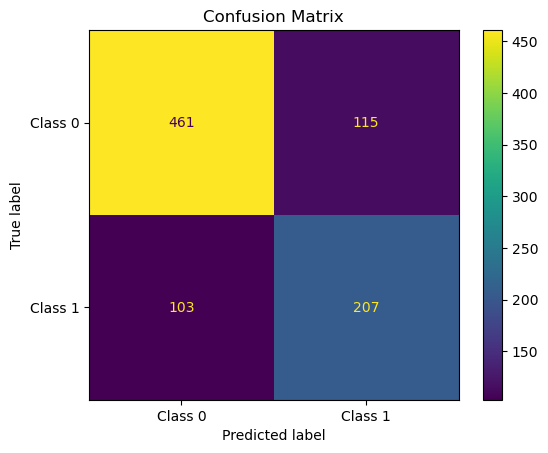

Model Metrics
AUC:  79.53
Accuracy:  75.4
Sensitivity:  66.77
Specificity:  80.03
Precision:  64.29
Negative Predictive Value:  81.74


In [19]:
y_pred_probs = model_grid.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_pred_probs)

# finding the best threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
best_index = np.argmax(tpr - fpr) 
best_threshold = thresholds[best_index]

# outputting confusion matrix
y_preds_optim = y_pred_probs >= best_threshold
y_preds_optim = y_preds_optim.astype(int)
cm_rf = confusion_matrix(y_test, y_preds_optim)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Class 0", "Class 1"]) # Adjust labels as needed
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# outputting the model assessment metrics
print('Model Metrics')
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_optim).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)
precision = tp / (fp + tp)
neg_pred_value = tn / (fn + tn)
acc  = (tp + tn) / (tn + fp + fn + tp)

print('AUC: ', round(auc_score*100,2))
print('Accuracy: ', round(acc*100,2))
print('Sensitivity: ', round(sensitivity*100,2))
print('Specificity: ', round(specificity*100,2))
print('Precision: ', round(precision*100,2))
print('Negative Predictive Value: ', round(neg_pred_value*100,2))

#### Feature Importance Values

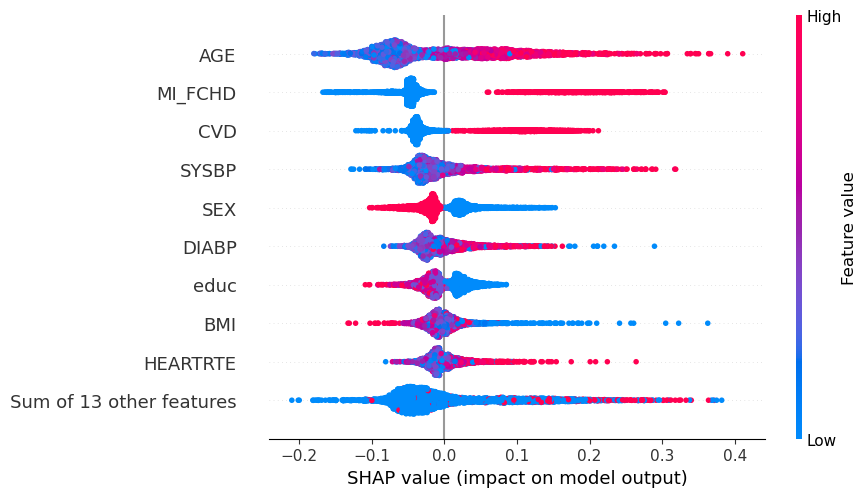

In [150]:
# SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(model_grid)

# SHAP on train set
shap_values = explainer(X_train)

# plotting the SHAP values
shap.plots.beeswarm(shap_values[:,:,1])

## Xgboost

#### Finding Optimal Hyperparameters

In [182]:
param_grid_xgb = {
    'max_depth': [x for x in range(2,round(0.7*len(X_train.columns))+1)],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1]
}

xgb_model = xgb.XGBClassifier(enable_categorical=True, eval_metric='auc')

# Create the GridSearchCV object
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5)

# Fit the GridSearchCV object to the training data
grid_xgb.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
Best score:  0.7745179681757682


#### Testing the optimized model

In [184]:
xgb_opt = xgb.XGBClassifier(max_depth=3,
                            learning_rate=0.1,
                            subsample=0.5,
                            enable_categorical=True)
xgb_opt.fit(X_train, y_train)
y_pred_xgb = xgb_opt.predict(X_test)
print(classification_report(y_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       645
           1       0.57      0.73      0.64       241

    accuracy                           0.78       886
   macro avg       0.73      0.76      0.74       886
weighted avg       0.80      0.78      0.79       886



#### Model Metrics on the Test Dataset

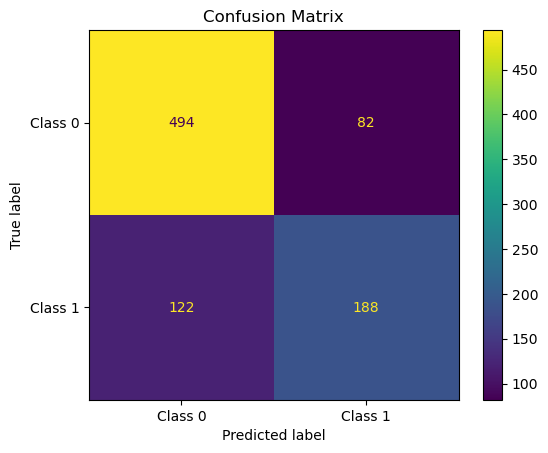

Model Metrics
AUC:  79.26
Accuracy:  76.98
Sensitivity:  60.65
Specificity:  85.76
Precision:  69.63
Negative Predictive Value:  80.19


In [186]:
y_pred_probs_xgb = xgb_opt.predict_proba(X_test)[:,1]
auc_score_xgb = roc_auc_score(y_test, y_pred_probs_xgb)

# finding the best threshold
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_probs_xgb)
best_index_xgb = np.argmax(tpr_xgb - fpr_xgb) 
best_threshold_xgb = thresholds_xgb[best_index_xgb]

# outputting confusion matrix
y_preds_optim_xgb = y_pred_probs_xgb >= best_threshold_xgb
y_preds_optim_xgb = y_preds_optim_xgb.astype(int)
cm_rf_xgb = confusion_matrix(y_test, y_preds_optim_xgb)

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_rf_xgb, display_labels=["Class 0", "Class 1"]) # Adjust labels as needed
disp_xgb.plot()
plt.title("Confusion Matrix")
plt.show()

# outputting the model assessment metrics
print('Model Metrics')
tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_matrix(y_test, y_preds_optim_xgb).ravel()
specificity_xgb = tn_xgb / (tn_xgb + fp_xgb)
sensitivity_xgb = tp_xgb / (tp_xgb + fn_xgb)
precision_xgb = tp_xgb / (fp_xgb + tp_xgb)
neg_pred_value_xgb = tn_xgb / (fn_xgb + tn_xgb)
acc_xgb  = (tp_xgb + tn_xgb) / (tn_xgb + fp_xgb + fn_xgb + tp_xgb)

print('AUC: ', round(auc_score_xgb*100,2))
print('Accuracy: ', round(acc_xgb*100,2))
print('Sensitivity: ', round(sensitivity_xgb*100,2))
print('Specificity: ', round(specificity_xgb*100,2))
print('Precision: ', round(precision_xgb*100,2))
print('Negative Predictive Value: ', round(neg_pred_value_xgb*100,2))

#### Feature Importance

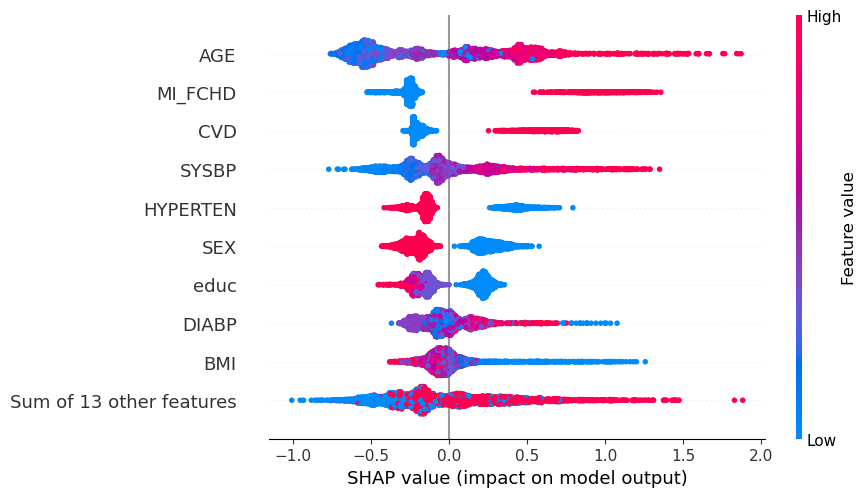

In [188]:
# SHAP explainer for the Random Forest model
explainer_xgb = shap.TreeExplainer(xgb_opt)

# SHAP on train set
shap_values_xgb = explainer_xgb(X_train)

# plotting the SHAP values
shap.plots.beeswarm(shap_values_xgb)